In [146]:
# Cell 1: Setup and All Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Advanced Visualization & ML Libraries
import shap
from joypy import joyplot
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

# Set plot style for better aesthetics
plt.style.use('seaborn-v0_8-darkgrid')

print("✅ All necessary libraries, including advanced ones like SHAP, have been imported.")

✅ All necessary libraries, including advanced ones like SHAP, have been imported.


In [147]:
# Cell 2: Load Raw Data
try:
    # Use the absolute paths to prevent file not found errors
    trader_df = pd.read_csv('/historical_data.csv')
    sentiment_df = pd.read_csv('/fear_greed_index.csv')
    print("✅ Raw data loaded successfully using absolute paths.")
except FileNotFoundError as e:
    print(f"File loading error: {e}")
    print("🚨 Please ensure 'historical_data.csv' and 'fear_greed_index.csv' are uploaded to the Colab root directory.")

✅ Raw data loaded successfully using absolute paths.


In [148]:
# Cell 3: Preprocess and Merge Datasets
def preprocess_and_merge(trader_df, sentiment_df):
    """Cleans, preprocesses, and merges the raw trader and sentiment data."""
    trader_df.columns = trader_df.columns.str.lower().str.replace(' ', '_')
    trader_df['timestamp_ist'] = pd.to_datetime(trader_df['timestamp_ist'], format='%d-%m-%Y %H:%M')
    trader_df['date'] = trader_df['timestamp_ist'].dt.date

    sentiment_df.rename(columns={'value': 'sentiment_value', 'classification': 'sentiment_classification'}, inplace=True)
    sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date

    merged_df = pd.merge(trader_df, sentiment_df, on='date', how='left')
    merged_df.dropna(subset=['sentiment_classification'], inplace=True)
    return merged_df

# Execute the function to create the 'merged_data' variable
merged_data = preprocess_and_merge(trader_df, sentiment_df)
print("✅ 'merged_data' DataFrame is now created and ready.")

✅ 'merged_data' DataFrame is now created and ready.


--- Generating Advanced Time Series Visualization ---


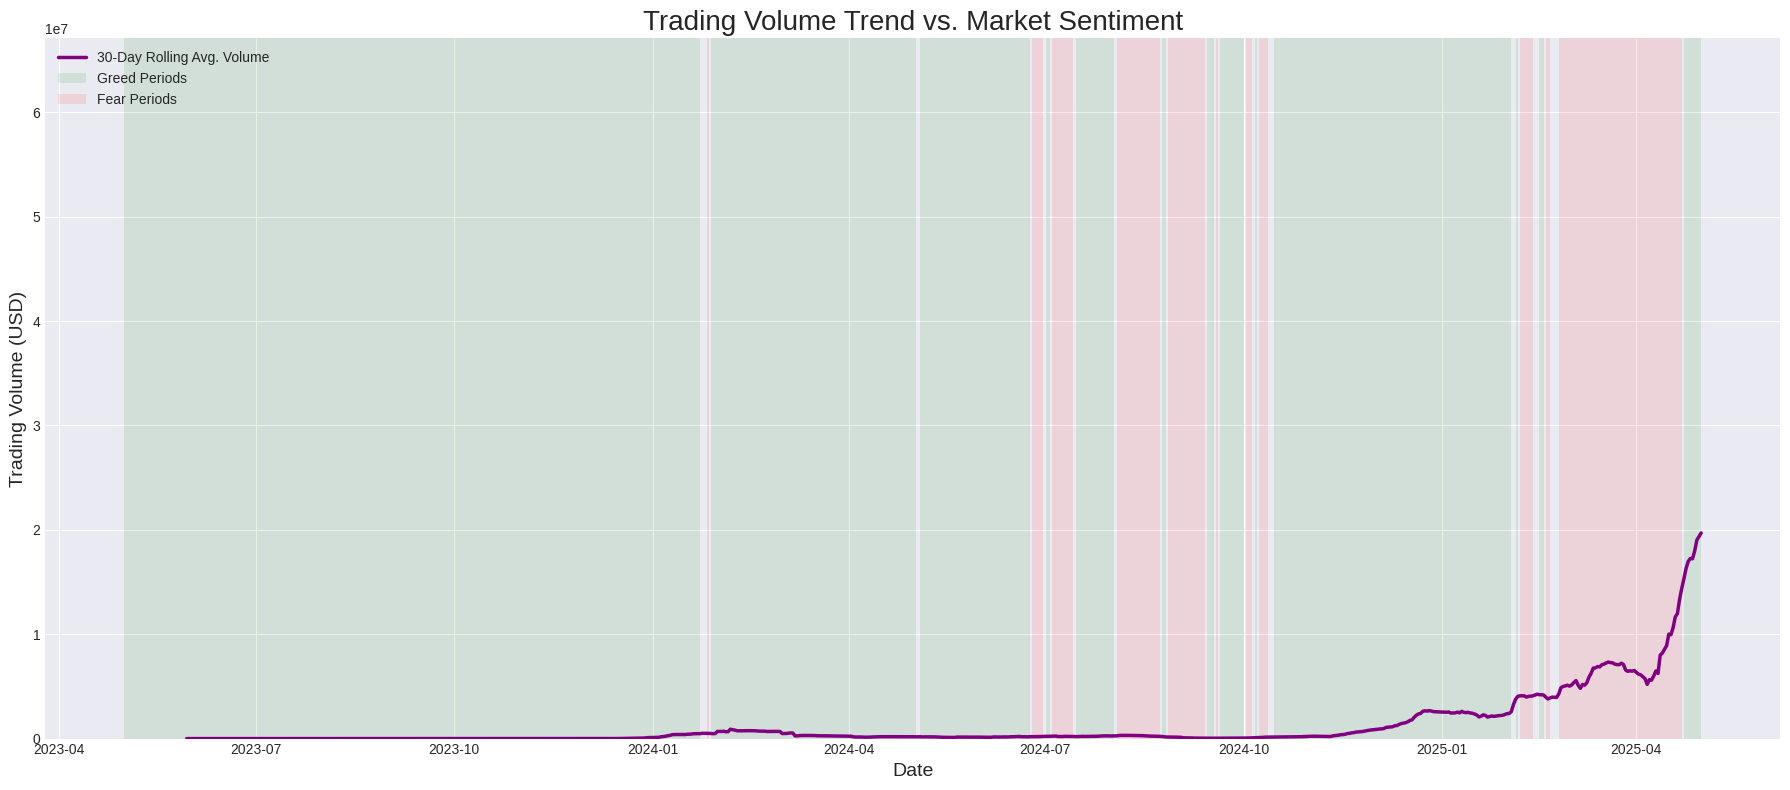

In [149]:
# Cell 4: Advanced Time Series Trend Visualization
print("--- Generating Advanced Time Series Visualization ---")
merged_data_sorted = merged_data.sort_values('timestamp_ist').set_index('timestamp_ist')
daily_volume = merged_data_sorted['size_usd'].resample('D').sum()
daily_sentiment = merged_data_sorted['sentiment_value'].resample('D').mean().ffill()

daily_volume_30d_ma = daily_volume.rolling(window=30).mean()

fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(daily_volume_30d_ma.index, daily_volume_30d_ma, label='30-Day Rolling Avg. Volume', color='purple', linewidth=2.5)

ax.fill_between(daily_sentiment.index, 0, daily_volume.max() * 1.2, where=daily_sentiment >= 50, facecolor='green', alpha=0.1, label='Greed Periods')
ax.fill_between(daily_sentiment.index, 0, daily_volume.max() * 1.2, where=daily_sentiment < 50, facecolor='red', alpha=0.1, label='Fear Periods')

ax.set_title('Trading Volume Trend vs. Market Sentiment', fontsize=20)
ax.set_ylabel('Trading Volume (USD)', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylim(0, daily_volume.max() * 1.2)
ax.legend()
plt.tight_layout()
plt.show()

In [150]:
# Cell 5: Engineer Trader Profile Features
def create_trader_profiles(df):
    """Aggregates data to the trader level to create behavioral features."""
    df['simplified_sentiment'] = df['sentiment_classification'].apply(lambda c: 'Greed' if 'Greed' in str(c) else 'Fear')
    realized_pnl = df[df['closed_pnl'] != 0]

    trader_features = df.groupby('account').agg(total_trades=('account', 'count'), total_volume_usd=('size_usd', 'sum'), avg_trade_size_usd=('size_usd', 'mean'), days_active=('date', 'nunique'))
    pnl_features = realized_pnl.groupby('account').agg(avg_pnl=('closed_pnl', 'mean'), win_rate=('closed_pnl', lambda x: (x > 0).sum() / x.count()))
    sentiment_behavior = df.groupby('account')['simplified_sentiment'].value_counts(normalize=True).unstack(fill_value=0)
    sentiment_behavior.rename(columns={'Fear': 'fear_trade_prop', 'Greed': 'greed_trade_prop'}, inplace=True)

    trader_profiles = pd.concat([trader_features, pnl_features, sentiment_behavior], axis=1)
    trader_profiles.fillna(0, inplace=True)
    return trader_profiles

trader_profiles = create_trader_profiles(merged_data)
print("✅ Trader profiles created successfully.")

✅ Trader profiles created successfully.


--- Generating Clustered Heatmap for Trader Personas ---


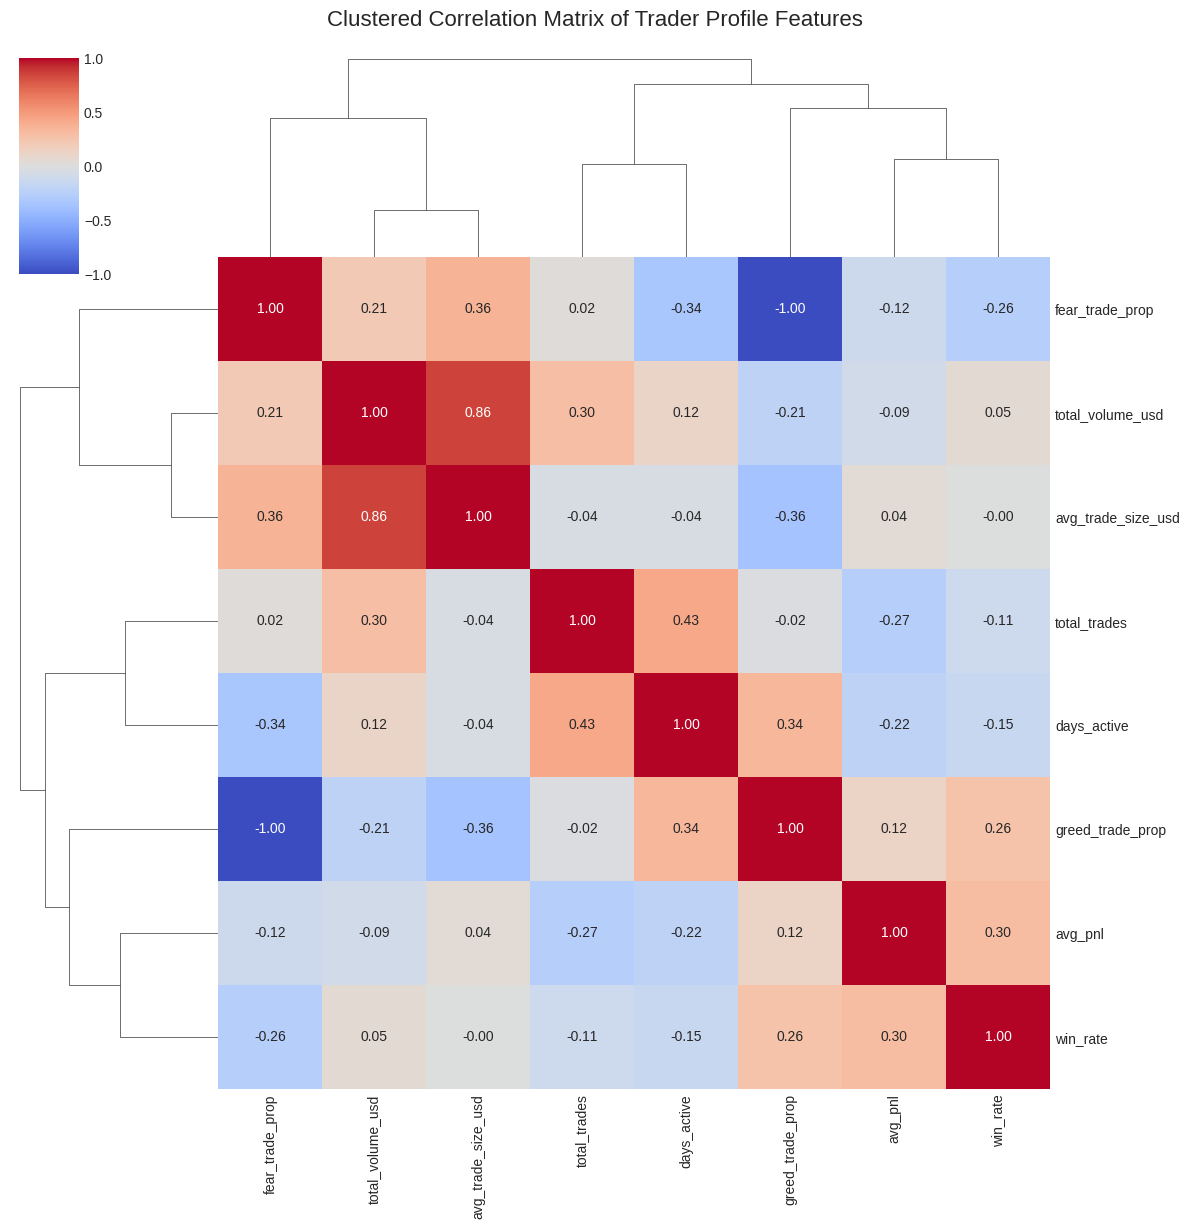

In [152]:
# Cell 6: Clustered Correlation Heatmap
print("--- Generating Clustered Heatmap for Trader Personas ---")
corr_matrix = trader_profiles.corr()
g = sns.clustermap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", figsize=(12, 12))
g.fig.suptitle('Clustered Correlation Matrix of Trader Profile Features', fontsize=16, y=1.02)
plt.show()

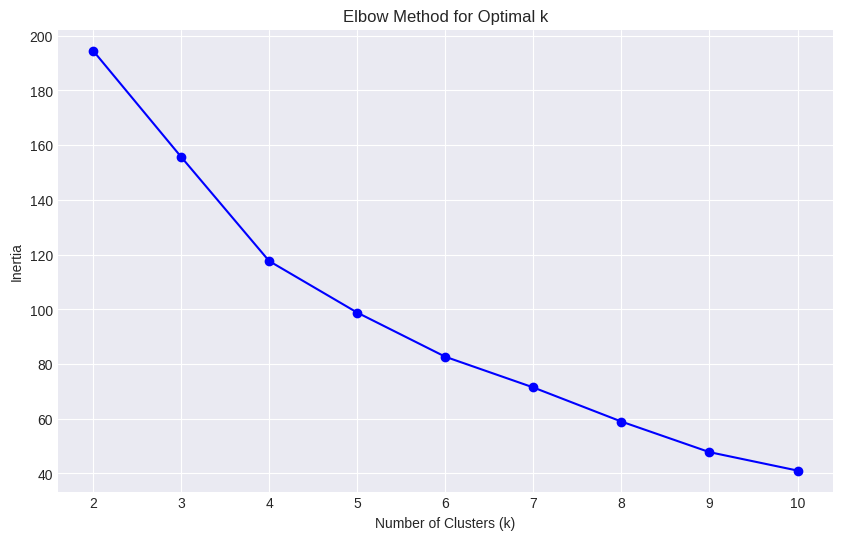

ℹ️ Inspect the plot for an 'elbow' point (e.g., k=4) and use it in the next cell.


In [153]:
# Cell 7: Determine Optimal Number of Clusters (Elbow Method)
features_for_clustering = trader_profiles[['total_trades', 'total_volume_usd', 'avg_trade_size_usd', 'days_active', 'avg_pnl', 'win_rate', 'fear_trade_prop', 'greed_trade_prop']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_for_clustering)

inertia = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)
plt.show()
print("ℹ️ Inspect the plot for an 'elbow' point (e.g., k=4) and use it in the next cell.")

✅ Clustering complete with 4 clusters.


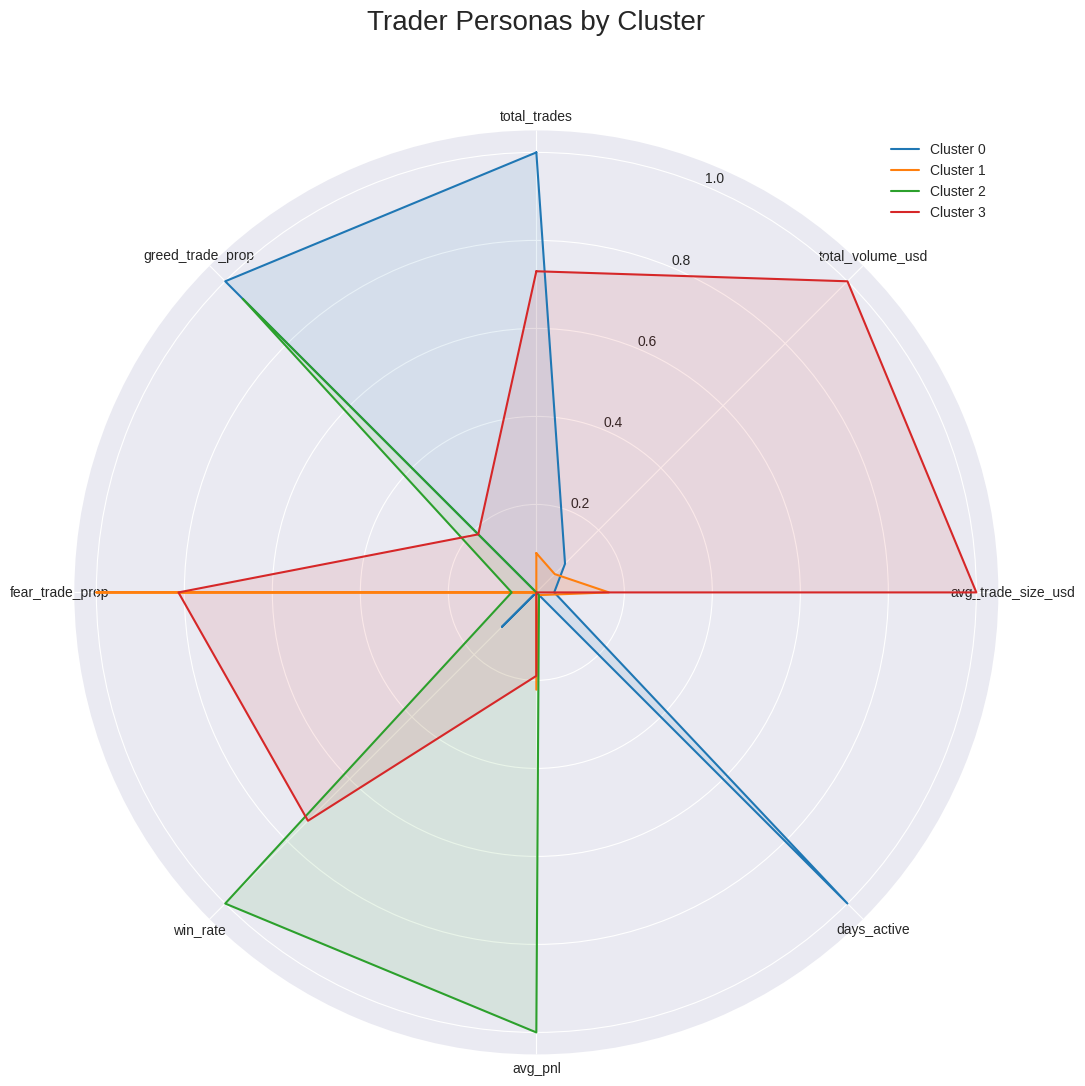

In [154]:
# Cell 8: Perform Clustering and Visualize Personas (Radar Chart)
OPTIMAL_K = 4 # Change this value based on your elbow plot
kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
trader_profiles['cluster'] = kmeans.fit_predict(scaled_features)
cluster_analysis = trader_profiles.groupby('cluster').mean()
print(f"✅ Clustering complete with {OPTIMAL_K} clusters.")

cluster_analysis_normalized = (cluster_analysis - cluster_analysis.min()) / (cluster_analysis.max() - cluster_analysis.min())
labels = cluster_analysis_normalized.columns
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))
for i, row in cluster_analysis_normalized.iterrows():
    values = row.values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.1)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
plt.title('Trader Personas by Cluster', size=20, y=1.1)
plt.legend()
plt.show()

--- Generating Ridgeline Plot for PnL Distribution by Persona and Sentiment ---


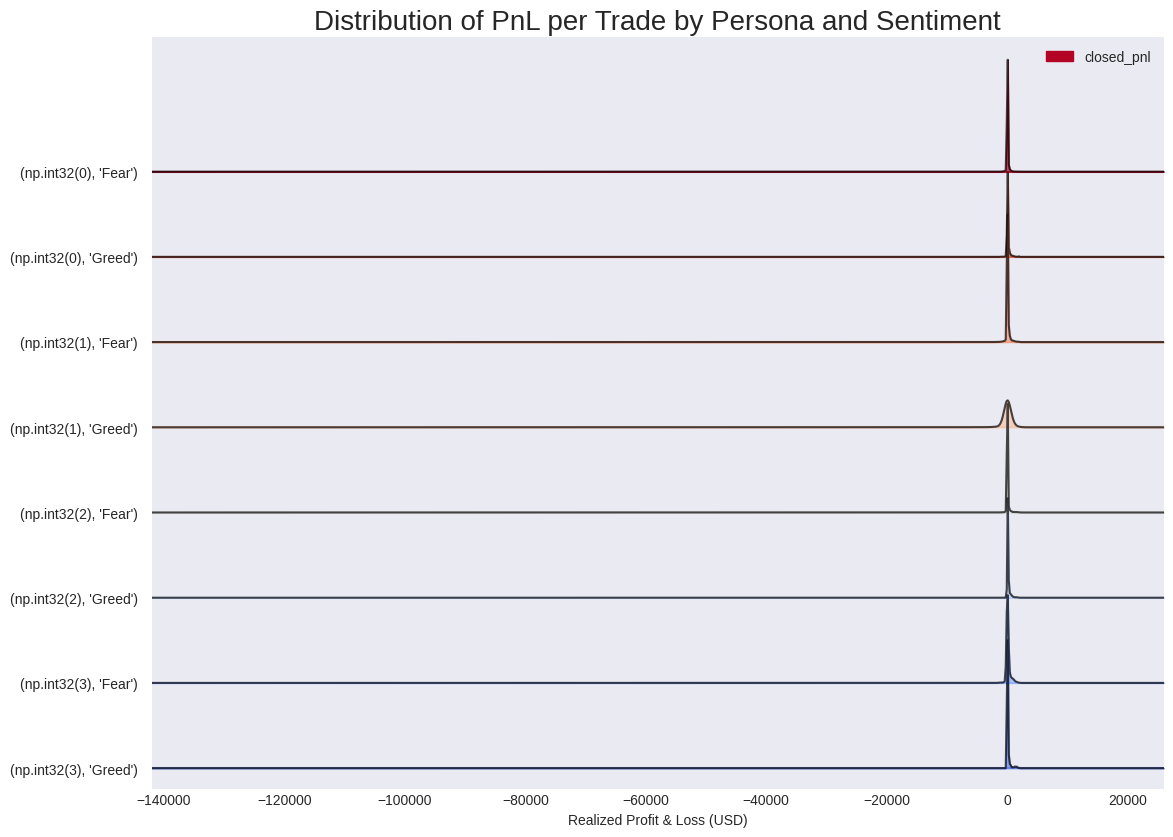

✅ Ridgeline plot generated successfully.
➡️ This plot shows the shape of profitability for each persona. A tall, narrow peak on the right means consistent profits. A wide, flat distribution means high-risk, unpredictable results.


In [155]:
# Corrected Cell 9: Performance Distribution with Ridgeline Plot
print("--- Generating Ridgeline Plot for PnL Distribution by Persona and Sentiment ---")

# Merge cluster assignments back to the main transactional dataframe
merged_data_with_clusters = merged_data.merge(trader_profiles['cluster'], on='account', how='left')

# Filter for trades with realized PnL and remove extreme outliers for better visualization
realized_pnl_with_clusters = merged_data_with_clusters[merged_data_with_clusters['closed_pnl'] != 0]
pnl_quantile = realized_pnl_with_clusters['closed_pnl'].quantile(0.99)
pnl_filtered = realized_pnl_with_clusters[realized_pnl_with_clusters['closed_pnl'] < pnl_quantile]

# Create the ridgeline plot
# THE FIX IS HERE: We added the 'column="closed_pnl"' argument
fig, axes = joyplot(
    data=pnl_filtered,
    by=['cluster', 'simplified_sentiment'],
    column='closed_pnl',  # <-- This line fixes the error
    figsize=(12, 8),
    legend=True,
    alpha=0.7,
    colormap=plt.cm.coolwarm_r
)

plt.title('Distribution of PnL per Trade by Persona and Sentiment', fontsize=20)
plt.xlabel('Realized Profit & Loss (USD)')
plt.show()

print("✅ Ridgeline plot generated successfully.")
print("➡️ This plot shows the shape of profitability for each persona. A tall, narrow peak on the right means consistent profits. A wide, flat distribution means high-risk, unpredictable results.")

--- Building a Profitability Prediction Model and Explaining it with SHAP ---
[LightGBM] [Info] Number of positive: 60804, number of negative: 12277
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2100
[LightGBM] [Info] Number of data points in the train set: 73081, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.832008 -> initscore=1.599928
[LightGBM] [Info] Start training from score 1.599928

--- Generating SHAP Plots using the Modern API ---

--- Generating SHAP Bar Plot ---


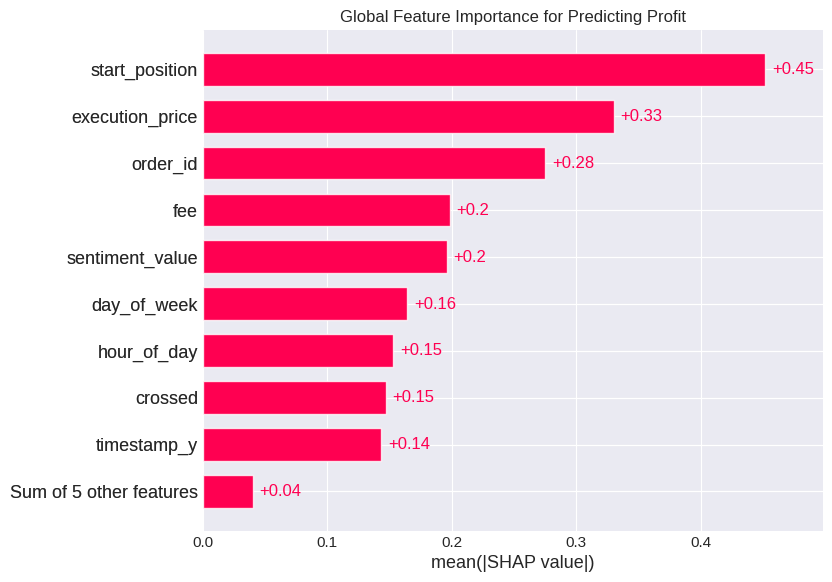


--- Generating SHAP Beeswarm (Dot) Plot ---


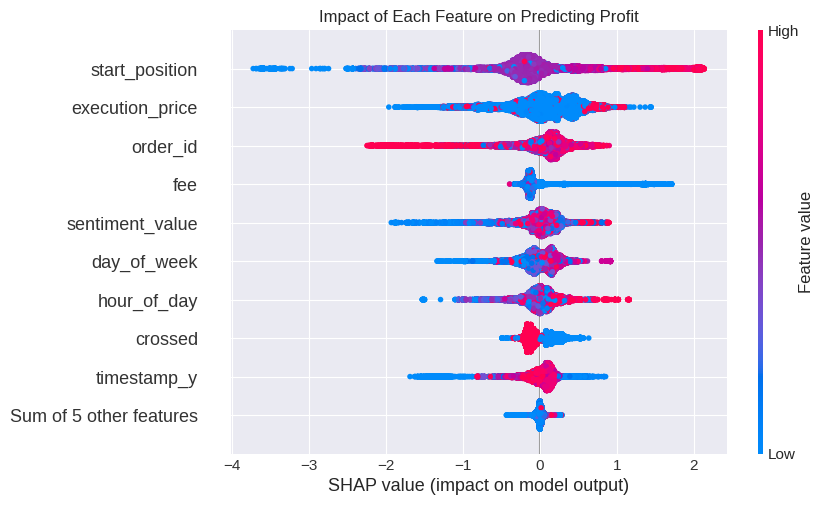


➡️ SHAP analysis complete. This dot plot shows the precise impact of each feature on the model's prediction of a trade being profitable.

➡️ HOW TO READ THE SHAP DOT PLOT:
1. Each dot is a single trade from the test set.
2. Y-axis: Features are ranked by importance.
3. X-axis: The SHAP value. Positive values push the prediction towards 'Profit', negative values push it towards 'Loss'.
4. Color: Red indicates a high value for that feature, blue indicates a low value.


In [159]:
# Final Corrected Cell 10: Profitability Prediction & SHAP Explainability

print("--- Building a Profitability Prediction Model and Explaining it with SHAP ---")

# --- Feature Engineering (as before) ---
model_df = merged_data[merged_data['closed_pnl'] != 0].copy()
model_df['hour_of_day'] = model_df['timestamp_ist'].dt.hour
model_df['day_of_week'] = model_df['timestamp_ist'].dt.dayofweek
model_df.drop(columns=['account', 'coin', 'side', 'timestamp_ist', 'direction', 'transaction_hash', 'date', 'sentiment_classification'], inplace=True, errors='ignore')
model_df['is_profitable'] = (model_df['closed_pnl'] > 0).astype(int)
model_df.drop(columns=['closed_pnl'], inplace=True)
model_df = pd.get_dummies(model_df, columns=['simplified_sentiment'], drop_first=True)

# --- Train the Model (as before) ---
X = model_df.drop('is_profitable', axis=1)
y = model_df['is_profitable']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
model = LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

# --- Explain the Model with the MODERN SHAP API ---
print("\n--- Generating SHAP Plots using the Modern API ---")
explainer = shap.TreeExplainer(model)

# Create a SHAP Explanation object. For this binary case, it correctly defaults to a 2D object.
shap_explanation = explainer(X_test)

# --- Plot 1: Bar plot for global feature importance (Corrected) ---
# We no longer need to slice the explanation object.
print("\n--- Generating SHAP Bar Plot ---")
shap.plots.bar(shap_explanation, show=False)
plt.title("Global Feature Importance for Predicting Profit")
plt.show()

# --- Plot 2: Detailed beeswarm plot (the modern dot plot) (Corrected) ---
# We also remove the slice here.
print("\n--- Generating SHAP Beeswarm (Dot) Plot ---")
shap.plots.beeswarm(shap_explanation, show=False)
plt.title("Impact of Each Feature on Predicting Profit")
plt.show()

print("\n➡️ SHAP analysis complete. This dot plot shows the precise impact of each feature on the model's prediction of a trade being profitable.")
print("\n➡️ HOW TO READ THE SHAP DOT PLOT:")
print("1. Each dot is a single trade from the test set.")
print("2. Y-axis: Features are ranked by importance.")
print("3. X-axis: The SHAP value. Positive values push the prediction towards 'Profit', negative values push it towards 'Loss'.")
print("4. Color: Red indicates a high value for that feature, blue indicates a low value.")